In [1]:
%config IPCompleter.use_jedi=False
%matplotlib inline

import pandas as pd
import sklearn 
import seaborn as sns

In [2]:
def load_data(path):
    dtype = {"tripduration":"Int64", #Note that this accepts nan values
              "start station id":"Int64",
              "start station name":"category",
              "start station latitude":"Float64",
              "start station longitude":"Float64",
              "end station id":"Int64",
              "end station name":"category",
              "end station latitude":"Float64",
              "end station longitude":"Float64",
              "bikeid":"Int64",
              "usertype":"category",
              "birth year":"Int64",
              "gender":"category"}
    data = pd.read_csv(path,parse_dates=["starttime","stoptime"])
    data = data.astype(dtype,copy=False) #Because reading category dtypes does not work out of the box
    return data

In [3]:
def print_memory_usage(data):
    memory = data.memory_usage(index=True,deep=True).sum()
    print(f"The dataframe needs {memory/1e9:.3} GB of memory")

In [4]:
data_train = load_data("Data/Train.csv")
print_memory_usage(data_train)
data_train.dtypes

The dataframe needs 1.83 GB of memory


tripduration                        Int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    Int64
start station name               category
start station latitude            Float64
start station longitude           Float64
end station id                      Int64
end station name                 category
end station latitude              Float64
end station longitude             Float64
bikeid                              Int64
usertype                         category
birth year                          Int64
gender                           category
roundtrip                            bool
haversine distance                float64
weekday                             int64
holiday                              bool
business day                         bool
speed                             float64
summer                               bool
dtype: object

## Exploratory Analysis

Lets see how unbalanced the classes are

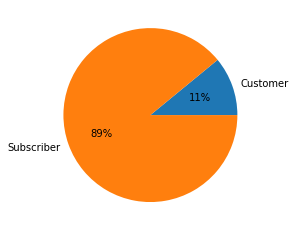

In [19]:
counts = data_train.groupby("usertype").size()
ax = counts.plot.pie(autopct='%1.0f%%',ylabel="")

### Distribution over month

Is this the same for each month?

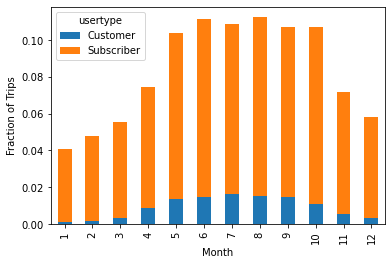

In [25]:
counts = data_train.groupby(by=["usertype",data_train["starttime"].dt.month]).size() / len(data_train)
counts = counts.unstack()
counts = counts.transpose()
ax = counts.plot.bar(stacked=True)
ax.set_xlabel("Month")
_ = ax.set_ylabel("Fraction of Trips")

We see that the amount of Customers varies more strongly with the month than the amount of subscribers.
This is easier to see by looking at the relative proportions of suscribers and customers for each month.

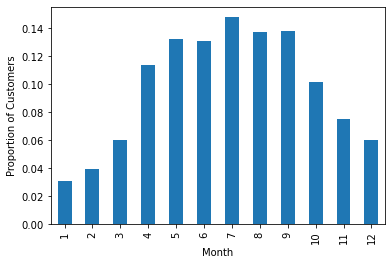

In [50]:
prop = counts.div(counts.sum(axis=1),axis=0)
ax=prop["Customer"].plot.bar(ylabel="Proportion of Customers",xlabel="Month",stacked=True)

### Holiday vs Business Day

Similarly, there are a lot more customers on weekends.

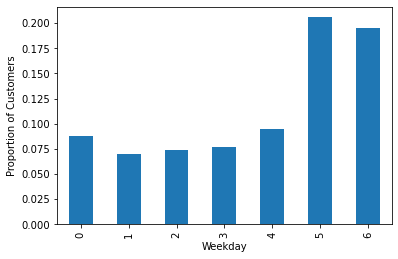

In [66]:
counts=data_train.groupby(["usertype","weekday"]).size() / len(data_train)
counts=counts.unstack().transpose()
prop = counts.div(counts.sum(axis=1),axis=0)
ax=prop["Customer"].plot.bar(ylabel="Proportion of Customers",xlabel="Weekday",stacked=True)

### Speed and Roundtrips

In [16]:
sampled = data_train.sample(n=100000)
sampled["tripduration"] /= 60

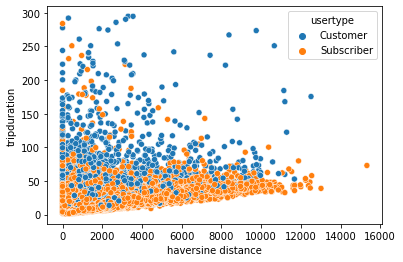

In [17]:
ax=sns.scatterplot(x="haversine distance",y="tripduration",data=sampled,hue="usertype")

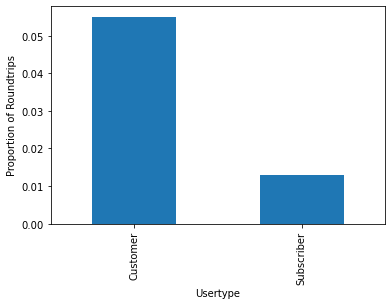

In [37]:
counts = data_train.groupby(["usertype", "roundtrip"]).size() / data_train.groupby("usertype").size()
counts=counts.unstack().transpose()
ax = counts.loc[True].plot.bar(ylabel="Proportion of Roundtrips",xlabel="Usertype")

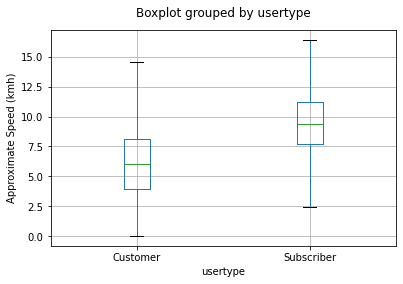

In [11]:
ax=data_train[data_train["roundtrip"]==False].boxplot("speed",by="usertype",showfliers=False)
ax.set_title("")
ax.set_ylabel("Approximate Speed (kmh)");

### Gender

### Gender

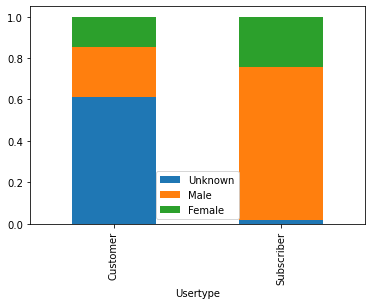

In [5]:
counts = data_train.groupby(["usertype","gender"]).size()
counts = counts/counts.groupby(level=0).sum() #Proportion in each group
counts=counts.unstack()
ax=counts.plot.bar(stacked=True,legend=["unknown","male","female"],xlabel="Usertype")
_=ax.legend(["Unknown","Male","Female"])

We see that for most customers, the gender is unknown, while for almost all subscribers the gender is known. This is potentially a very strong predictor for our model. However, for most use cases, this seems like "cheating". The gender = unknown category does not only mean the gender is unknown, it means that the customer will not provide the gender on registration. This can only be known after the fact, when it is also known whether the user made the trip as a customer or subscriber. Therefore, this is essentially using information "from the future" that will not be available in most use cases.

### Time of day of Trips

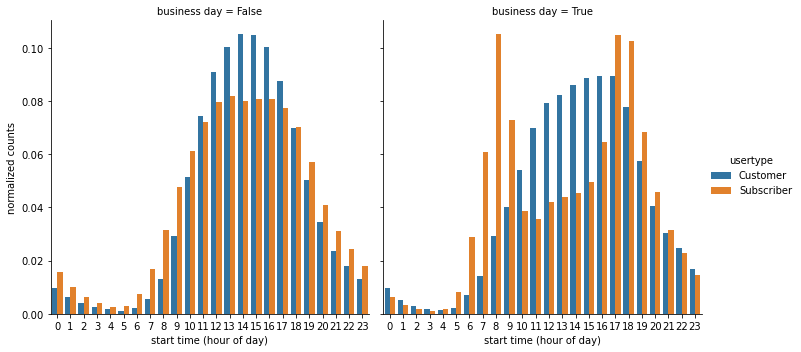

In [63]:
grouped = data_train.groupby(by = [data_train["starttime"].dt.hour,"business day","usertype"]).size()
grouped = grouped / grouped.groupby(level=["business day","usertype"]).sum() #Normlize by dividing by total trips per day
grouped = grouped.reset_index(name="normalized counts")
grouped=grouped.rename(columns={"starttime":"start time (hour of day)"})
sns.catplot(x="start time (hour of day)",y="normalized counts",hue="usertype",col="business day",kind="bar",data=grouped);

We see two interesting facts. The first is that the start times are strongly bimodal for subscribers on business day. Apparently, most subscribers use the bike on their ways to and from work. This is not the case for customers, whose traffic peaks in the afternoon. Thus, we can use the start time to differentiate these two groups.
The second interesting feature is that the difference between customers and subscribers ist far less pronounced on holidays and weekends. Thus, it might make sense to introduce an interaction variable between "start hour" and "business day" into our models.

### Stations

Let us also check if customers and subscribers tend to commute between different stations.

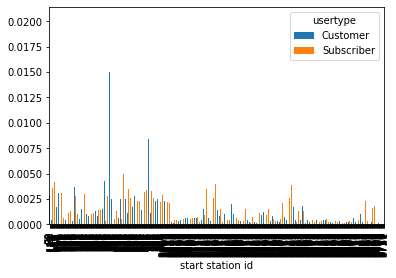

In [86]:
#First, lets just look at the start station
grouped = data_train.groupby(["usertype","start station id"]).size()
grouped = grouped / grouped.groupby(level="usertype").sum()
grouped_plot = grouped.unstack().transpose()
grouped_plot.plot.bar(by="usertype");

It seems like Subscribers are more evenly spread than Customers.

We can look at the ten most frequent start stations and see that there is no overlap betw:

In [98]:
k=10
grouped = data_train.groupby("usertype")["start station name"].value_counts()
print(f"The {k} most frequent stations for customers:")
print(grouped["Customer"][0:k])
print(f"The {k} most frequent stations for subscribers:")
print(grouped["Subscriber"][0:k])

The 10 most frequent stations for customers:
Central Park S & 6 Ave               31226
Grand Army Plaza & Central Park S    27109
Centre St & Chambers St              22978
5 Ave & E 88 St                      20722
12 Ave & W 40 St                     18963
Central Park West & W 72 St          16551
5 Ave & E 73 St                      16152
Pier 40 - Hudson River Park          14701
West St & Chambers St                13943
5 Ave & E 78 St                      13785
Name: start station name, dtype: int64
The 10 most frequent stations for subscribers:
Pershing Square North    112884
W 21 St & 6 Ave           81640
E 17 St & Broadway        80745
Broadway & E 22 St        78677
Broadway & E 14 St        69090
W 41 St & 8 Ave           65691
8 Ave & W 33 St           62564
Lafayette St & E 8 St     61981
West St & Chambers St     61135
8 Ave & W 31 St           59942
Name: start station name, dtype: int64
